In [1]:
import sys

path_to_stocker = 'stocker'
sys.path.insert(0, path_to_stocker)

In [2]:
from stocker import Stocker

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

## Load the Data

In [4]:
def select_subset(dataframe,n_companies, n_days,total_companies):
    np.random.seed(47)
    rand_idx = np.random.choice(total_companies,n_companies, replace=False)
    subset = dataframe.iloc[rand_idx]
    return subset.iloc[:,:n_days]

In [5]:
snp500 = pd.read_csv('../datasets/sp500/sp500.csv', index_col='Date')
snp500.index= pd.to_datetime(snp500.index)


In [6]:
snp500_validation = pd.read_csv('../datasets/sp500/sp500validation.csv', index_col='Date')
snp500_validation.index= pd.to_datetime(snp500_validation.index)

Get random labels for 100x453 cluster

In [60]:
# labels = pd.read_csv('./images/Agglomerative/Correlation/average-linkage/100x453_4_clusters/labels.csv', index_col='Company')
# labels = pd.read_csv('./images/Hdbscan/DTW/500x453_42_clusters/labels.csv', index_col='Company')

labels = pd.read_csv('./images/Agglomerative/Euclidean/average-linkage/500x453_31_clusters/labels.csv', index_col='Company')

In [61]:
labels.head()

Cluster
Company         
MMM            0
ABT            2
ABBV           2
ABMD          17
ACN           14

In [62]:
stocks = snp500[labels.index].copy()
stocks_validation = snp500_validation[snp500_validation.columns.intersection(labels.index)].copy()


#### Helpers

In [63]:
def norm_returns(dataframe):
    return dataframe / dataframe.iloc[0]

def log_returns(dataframe):
    return np.log(dataframe / dataframe.shift(1))

def sharpe_ratio(returns):
    

    daily_returns = returns.pct_change(1)

    SR = daily_returns.mean() / daily_returns.std()
    ASR = SR*(252 ** 0.5)
    return ASR




## Approach 1:

In [64]:
def select_portfolio(stocks,labels):
    portfolio_stocks = pd.DataFrame(index=stocks.index)
    stocks_log_return = norm_returns(stocks)
    for label in pd.unique(labels['Cluster']):
        cluster_companies = labels[labels['Cluster'] == label].index
        cluster_stocks = stocks_log_return[cluster_companies]
        highest_sharpe_ratio_company = sharpe_ratio(cluster_stocks).idxmax()
        portfolio_stocks[highest_sharpe_ratio_company] = stocks[highest_sharpe_ratio_company]
    
    
    return portfolio_stocks

In [65]:
portfolio_stocks = select_portfolio(stocks,labels)
portfolio_stocks.head()

LLY        ANTM        ABMD         NEE       ATVI  \
Date                                                                   
2017-01-03  71.276276  139.935349  112.360001  113.155746  36.230255   
2017-01-04  71.390938  139.749741  115.739998  113.489349  36.942204   
2017-01-05  72.222168  141.234665  114.809998  113.422623  37.515717   
2017-01-06  72.298607  141.019745  115.419998  113.089020  37.486053   
2017-01-09  72.871872  139.495728  117.110001  112.803078  37.278404   

                  CNC    AMD         AAP        AES       ARNC    ...      \
Date                                                              ...       
2017-01-03  58.310001  11.43  170.015747  10.698365  18.849598    ...       
2017-01-04  60.250000  11.43  171.410950  10.606611  19.350550    ...       
2017-01-05  60.150002  11.24  171.291336  10.468982  19.743454    ...       
2017-01-06  61.040001  11.32  169.049072  10.845169  20.264051    ...       
2017-01-09  61.970001  11.49  168.949417  10.579084  20.028307    ...       

                  IPGP        RHT   NKTR        NFLX        NRG        STX  \
Date                                                                         
2017-01-03   98.779999  70.120003  12.69  127.489998  12.189162  35.963673   
2017-01-04  100.070000  73.099998  13.16  129.410004  12.912582  35.509804   
2017-01-05   95.910004  73.099998  13.20  131.809998  13.160330  35.446266   
2017-01-06   95.150002  73.800003  13.75  131.070007  13.239609  34.937946   
2017-01-09   97.820000  72.139999  13.64  130.949997  13.348618  34.538555   

                 TTWO       TWTR       VRTX       WYNN  
Date                                                    
2017-01-03  49.220001  16.440001  74.889999  84.998398  
2017-01-04  50.139999  16.860001  77.050003  87.739029  
2017-01-05  49.360001  17.090000  79.059998  88.866394  
2017-01-06  49.950001  17.170000  79.389999  89.828537  
2017-01-09  50.459999  17.500000  82.860001  90.139519  

[5 rows x 31 columns]

In [66]:
portfolio_stocks.index.max()

Timestamp('2018-10-19 00:00:00')

## Predict Future Prices

In [67]:
def pred_stock(ticker):
    stock = Stocker(ticker,start_date=None, end_date='2018-10-22')
    stock.changepoint_prior_scale = 0.6
    model, model_data = stock.create_prophet_model(days=135)
    
    true_price = stocks_validation[ticker].loc[:model_data.ds.max()]
    pred_price = model_data.copy()
    pred_price = pred_price.set_index('ds')
    pred_price.index.names = ['Date']
    pred_price = pred_price.loc[true_price.index.min():]
    pred_price = pred_price['yhat']
    pred_price = pred_price.rename(ticker)
    return pred_price

In [68]:
def pred_portfolio_stocks(p_stocks):
    pred_prices = []
    for portfolio_stock in p_stocks.columns:
        pred_prices.append(pred_stock(portfolio_stock))
    
    return pd.concat(pred_prices, axis=1)
        
        

In [69]:
predicted_portfolio_stocks = pred_portfolio_stocks(portfolio_stocks)

LLY Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted Price on 2019-03-06 = $109.67
ANTM Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted Price on 2019-03-06 = $372.50
ABMD Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted Price on 2019-03-06 = $376.42
NEE Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted Price on 2019-03-06 = $179.99
ATVI Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted Price on 2019-03-06 = $69.83
CNC Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted Price on 2019-03-06 = $69.57
AMD Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted Price on 2019-03-06 = $12.71
AAP Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted Price on 2019-03-06 = $206.29
AES Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted Price on 2019-03-06 = $19.28
ARNC Stocker Initialized. Data covers 2010-01-04 to 2018-10-22.
Predicted 

### Portfolio Optimisation

In [70]:
from scipy.optimize import minimize

In [71]:
def get_ret_vol_sr(weights,stocks):
    returns = log_returns(stocks)
    weights = np.array(weights)
    ret = np.sum(returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sr = ret/vol
    return (ret,vol,sr)

def calc_portfolio_sharpe_ratio(weights,returns,pred_returns):
    weights = np.array(weights)
    ret = np.sum(pred_returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return ret/vol

def negative_sharpe(weights, returns, pred_returns):
    sr = calc_portfolio_sharpe_ratio(weights, returns,pred_returns)
    return sr * -1
    
def optimize_portfolio(portfolio,pred_portfolio):
    log_ret = log_returns(portfolio)
    pred_log_ret = log_returns(pred_portfolio)
    # By convention of minimize function it should be a function that returns zero for conditions
    cons = ({'type':'eq','fun': lambda x: np.sum(x) - 1})

    num_of_stocks = len(portfolio.columns)
    
    # 0-1 bounds for each weight
    bounds = np.full((num_of_stocks,2), (0,1))

    # Initial Guess (equal distribution)
    init_guess = np.full((1, num_of_stocks), 1 / num_of_stocks)
    # Sequential Least SQuares Programming (SLSQP).
    opt_results = minimize(negative_sharpe,init_guess,args=(log_ret,pred_log_ret),method='SLSQP',bounds=bounds,constraints=cons)
#     sharpe_ratio = calc_portfolio_sharpe_ratio(opt_results.x, log_ret)
    sharpe_ratio = get_ret_vol_sr(opt_results.x, portfolio)
    return (sharpe_ratio, opt_results.x)


In [72]:
sr, portfolio_allocation= optimize_portfolio(portfolio_stocks,predicted_portfolio_stocks)
print(sr)
print(portfolio_stocks.columns.values)
print(portfolio_allocation)

(0.2761449385448043, 0.14481662071297208, 1.9068594280495346)
['LLY' 'ANTM' 'ABMD' 'NEE' 'ATVI' 'CNC' 'AMD' 'AAP' 'AES' 'ARNC' 'ALGN'
 'FTNT' 'PGR' 'LRCX' 'ANET' 'BA' 'HCA' 'CMG' 'MAT' 'HFC' 'INCY' 'IPGP'
 'RHT' 'NKTR' 'NFLX' 'NRG' 'STX' 'TTWO' 'TWTR' 'VRTX' 'WYNN']
[8.73096237e-13 5.03513560e-01 3.24986348e-13 1.21799872e-12
 1.91773370e-13 4.46719267e-13 5.05290952e-13 9.50185502e-02
 3.35908533e-01 3.35454609e-13 1.26801761e-13 6.22580490e-13
 9.16366912e-13 4.47035614e-13 2.03376771e-13 6.92883011e-13
 6.81700035e-13 4.82308944e-13 9.95423077e-13 7.66300860e-13
 8.49875797e-14 2.09795714e-14 2.59746743e-13 2.11639756e-12
 1.42558967e-13 2.85320759e-02 3.70272806e-02 1.99355432e-13
 5.10512585e-13 2.58691483e-13 6.91111993e-13]


In [73]:
print(portfolio_stocks.index[0], portfolio_stocks.index[-1])

2017-01-03 00:00:00 2018-10-19 00:00:00


### Portfolio Validation

In [74]:
def calc_positions(stocks, allocation, investment):
    normed_returns = norm_returns(stocks)
    value = normed_returns * allocation * investment
    value['Total'] = value.sum(axis=1)
    return value

In [75]:
def calc_cumulative_return(positions, decimals=4):
    cum_return = 100 * (positions[-1]/positions[0] - 1)
    return np.round(cum_return, decimals)

In [76]:
from matplotlib.dates import WeekdayLocator

In [77]:
def bar_plot_labels(ax, data):
    for index, value in enumerate(data):
        max_value = data.max()
        ax.text(index-0.15, value-(max_value * 0.15), str(np.round(value,2)), fontweight='bold', color='white')



In [78]:
def plot_portfolio_validation(portfolio_positions, benchmark_positions,stats):    
    initial_investment = int(portfolio_positions.iloc[0])
    
    colors=('b', 'orange')
    opacity=0.7

    plt.figure(figsize=(26,16))
    plot_grid_size = (4,3)    
    # Plot Portfolio Value
    ax1 = plt.subplot2grid(plot_grid_size, (0, 0), colspan=3,rowspan=2)

    portfolio_positions.plot(ax=ax1,label='Portfolio')
    benchmark_positions.plot(ax=ax1, label='Benchmark',figsize=(12,9), grid=True)
    
    ax1.set_ylabel('Earnings')    
    ax1.xaxis.set_major_locator(WeekdayLocator(byweekday=1, interval=2))
    plt.title('Portfolio vs Benchmark, {}£ Inital Investment'.format(initial_investment))    
    plt.legend()

    # Plot Portfolio Cumulative Return
    ax2 = plt.subplot2grid(plot_grid_size, (2, 0))
    stats['Cumulative Return'].plot(ax=ax2, kind='bar', color=colors, alpha=opacity, rot=0, width=0.8)
    ax2.set_ylabel('Return %')
    ax2.set_title('Cumulative Return')
    bar_plot_labels(ax2,stats['Cumulative Return'])
    
        
    # Plot Portfolio Drawdown
    ax6 = plt.subplot2grid(plot_grid_size, (2,1))
    stats['Maximum Drawdown'].plot(ax=ax6, kind='bar', color=colors, alpha=opacity, rot=0, width=0.8)
    ax6.set_ylabel('Drawdown %')
    ax6.set_title('Maximum Drawdown')
    bar_plot_labels(ax6,stats['Maximum Drawdown'])

    
     
    # Plot Portfolio Drawdown
    ax7 = plt.subplot2grid(plot_grid_size, (2,2))
    stats['Average Drawdown'].plot(ax=ax7, kind='bar', color=colors, alpha=opacity, rot=0, width=0.8)
    ax7.set_ylabel('Drawdown %')
    ax7.set_title('Average Drawdown')
    bar_plot_labels(ax7,stats['Average Drawdown'])



    # Plot Portfolio Sharpe Ratio
    ax3 = plt.subplot2grid(plot_grid_size, (3, 0))
    stats['Sharpe Ratio'].plot(ax=ax3, kind='bar', color=colors, alpha=opacity, rot=0, width=0.8)
    ax3.set_ylabel('Sharpe Ratio')
    ax3.set_title('Sharpe Ratio')
    bar_plot_labels(ax3,stats['Sharpe Ratio'])

    # Plot Portfolio Expected Return
    ax4 = plt.subplot2grid(plot_grid_size, (3,1))
    stats['Expected Return'].plot(ax=ax4, kind='bar', color=colors, alpha=opacity, rot=0, width=0.8)
    ax4.set_ylabel('Return')
    ax4.set_title('Expected Log Return')
    bar_plot_labels(ax4,stats['Expected Return'])

    # Plot Portfolio Expected Volatility
    ax5 = plt.subplot2grid(plot_grid_size, (3,2))
    stats['Expected Volatility'].plot(ax=ax5, kind='bar', color=colors, alpha=opacity, rot=0, width=0.8)
    ax5.set_ylabel('Volatility')
    ax5.set_title('Expected Log Volatility')
    bar_plot_labels(ax5,stats['Expected Volatility'])
    

    plt.tight_layout()
    plt.show()

    

In [79]:
import ffn

def validate_portfolio(portfolio, allocation, validation_stocks, investment=10000):
    portfolio_val = calc_positions(validation_stocks[portfolio.columns], allocation, investment)
    
    # Equal Allocation of the Benchmark Stocks
    benchmar_companies_count = len(validation_stocks.columns)
    benchmark_allocation = np.full(benchmar_companies_count, 1 / benchmar_companies_count)
    benchmark_val = calc_positions(validation_stocks, benchmark_allocation, investment)
    
    # Calculate Statistics
    p_cum_ret = calc_cumulative_return(portfolio_val['Total'])
    bm_cum_ret = calc_cumulative_return(benchmark_val['Total'])
    p_exp_ret, p_exp_vol, p_sr = get_ret_vol_sr(weights=allocation, stocks=portfolio)
    bm_exp_ret, bm_exp_vol, bm_sr = get_ret_vol_sr(weights=benchmark_allocation, stocks=validation_stocks)
    
    p_stats = ffn.GroupStats(portfolio_val)['Total'].stats
    bm_stats = ffn.GroupStats(benchmark_val)['Total'].stats
    
    
    validation_stats = pd.DataFrame(
        index=['Portfolio', 'Benchmark'],
        columns=['Cumulative Return','Sharpe Ratio','Expected Return','Expected Volatility', 'Maximum Drawdown', 'Average Drawdown', 'DSR', 'MSR'],
        data=[[p_cum_ret,p_sr,p_exp_ret,p_exp_vol, p_stats['max_drawdown'] * 100,  p_stats['avg_drawdown'] * 100, p_stats.daily_sharpe, p_stats.monthly_sharpe],
              [bm_cum_ret,bm_sr,bm_exp_ret,bm_exp_vol,bm_stats['max_drawdown'] * 100, bm_stats['avg_drawdown'] * 100, bm_stats.daily_sharpe, p_stats.monthly_sharpe]]
    )
    
    plot_portfolio_validation(portfolio_val['Total'], benchmark_val['Total'], validation_stats)
    
    
    return validation_stats

  

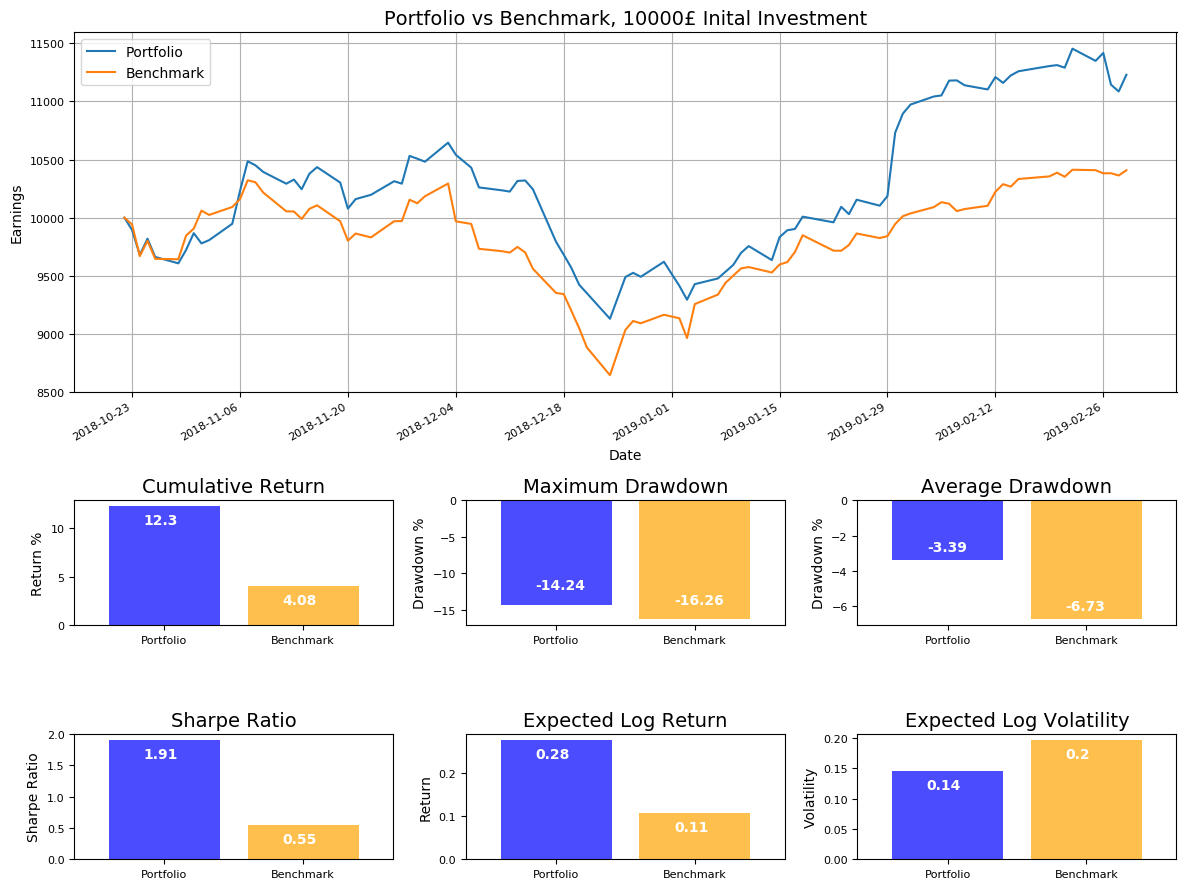

In [80]:
stats = validate_portfolio(portfolio_stocks, portfolio_allocation, stocks_validation)

In [81]:
stats

Cumulative Return  Sharpe Ratio  Expected Return  \
Portfolio            12.2978      1.906859         0.276145   
Benchmark             4.0827      0.548131         0.107846   

           Expected Volatility  Maximum Drawdown  Average Drawdown       DSR  \
Portfolio             0.144817        -14.237106         -3.385755  1.590745   
Benchmark             0.196753        -16.257187         -6.734818 -1.908151   

                MSR  
Portfolio  1.265209  
Benchmark  1.265209